# 05wk-1: (신경망) – 예측, 시벤코정리의 이면, 드랍아웃

최규빈  
2025-04-02

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/05wk-1
    .ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-yx6DQsLACqw8pWm0udv8Jm&si=in1eMD0-wU49y7mS>

# 2. Imports

In [5]:
import torch
import matplotlib.pyplot as plt

In [6]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

# 3. 예측

In [7]:
# (x,y)
# 언더라잉 <-- 우리의 진목표 X
# 예측 <-- 이게 진짜 우리의 목표 

## A. 데이터

In [8]:
torch.manual_seed(43052)
x,_ = torch.randn(100).sort()
eps = torch.randn(100)*0.5
y = x * 4 + 2.5 + eps
x,y = x.reshape(-1,1), y.reshape(-1,1)

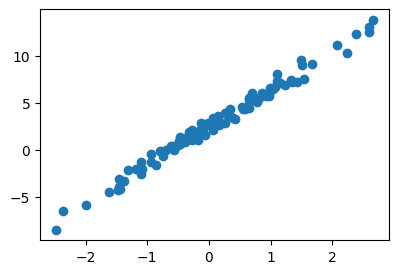

In [9]:
plt.plot(x,y,'o')

## B. 학습

In [10]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
## 
for epoc in range(200):
    ## step1 
    yhat = net(x) 
    ## step2 
    loss = loss_fn(yhat,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

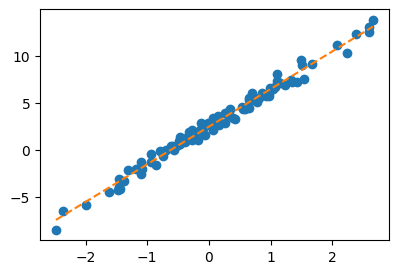

In [11]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--')

In [12]:
net[0].weight, net[0].bias

## C. 예측

온도가 0.1 도일때, 커피를 얼마나 팔까?

In [13]:
0.1 * 4.0042 + 2.4459 

In [14]:
xx = torch.tensor([[0.1]])
net(xx)

온도가 0.2도일때 커피를 얼마나 팔까?

In [15]:
0.2 * 4.0042 + 2.4459 

In [16]:
xx = torch.tensor([[0.2]])
net(xx)

온도가 \[0.1, 0.2\] 일때의 예측값을 한번에 보고 싶다면?

In [17]:
xx = torch.tensor([[0.1],
                   [0.2]])
net(xx)

> **Note**
>
> 이거 질문이 와서 좀 더 자세히 설명하겠습니다. (아직 `net(x)`의 계산
> 과정을 선형 변환 관점에서 수식으로 정리하는 데 익숙하지 않으셔서 그럴
> 수 있습니다. 이건 단순 산수라서 하나씩 차근차근 따라가다 보면 충분히
> 이해하실 수 있어요. 처음부터 바로 이해되지 않더라도 전혀 걱정하실 필요
> 없습니다.)
>
> 하나의 값 $x$에 대하여 $net(x)$는 아래를 의미하는 연산을 합니다.
>
> ``` python
> net(x) = 4.0042 * x + 2.4459  = net[0].weight * x + net[0].bias
> ```
>
> 사실 위의 과정을 수식으로 엄밀하게 쓰면 아래와 같습니다.
>
> $$net(\begin{bmatrix} x \end{bmatrix}) = 2.4459 + \begin{bmatrix} x \end{bmatrix} \begin{bmatrix} 4.0042 \end{bmatrix}$$
>
> 여기에서 $\begin{bmatrix} x \end{bmatrix}$ 와
> $\begin{bmatrix} 4.0042  \end{bmatrix}$ 는 모두 $1\times 1$ matrix를
> 의미합니다. 만약에 $2 \times 1$ matrix
> ${\bf x} = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$를 네트워크의
> 입력으로 고려한다면 아래와 같이 됩니다.
>
> $$net({\bf x})=net\left(\begin{bmatrix}x_1 \\ x_2 \end{bmatrix}\right) = 2.4459 + \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \begin{bmatrix} 4.0042 \end{bmatrix} = \begin{bmatrix} 2.4459 + 4.0042 x_1 \\ 2.4459 + 4.0042 x_2\end{bmatrix} $$
>
> 따라서 ${\bf xx} = \begin{bmatrix} 0.1 \\ 0.2 \end{bmatrix}$ 를
> 네트워크의 입력으로 넣으면
>
> $$net({\bf xx})= \begin{bmatrix} 2.4459 + 4.0042 \times 0.1 \\ 2.4459 + 4.0042 \times 0.2\end{bmatrix}= \begin{bmatrix} 2.8463 \\ 3.2467 \end{bmatrix}$$
>
> 와 같이 계산되겠죠.

# 4. 오버피팅 (시벤코정리의 이면)

## A. 오버피팅

`-` 오버피팅이란?

-   위키: In mathematical modeling, overfitting is “the production of an
    analysis that corresponds too closely or exactly to a particular set
    of data, and may therefore fail to fit to additional data or predict
    future observations reliably”. (수학적 모델링에서 과적합이란 “어떤
    모델이 주어진 데이터에 너무 꼭 맞춰져 있어서, 새로운 데이터나 미래의
    결과를 잘 예측하지 못할 수 있는 상태”를 의미한다.)
-   제 개념: 데이터를 “데이터 = 언더라잉 + 오차”라고 생각할때 우리가
    데이터로부터 적합할 것은 언더라잉인데 오차항을 적합하고 있는 현상.

## B. 오버피팅 예시

`-` $m$이 매우 클때 아래의 네트워크 거의 무엇이든 맞출 수 있다고 보면
된다.

-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$
-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$
-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 그런데 종종 맞추지 말아야 할 것들도 맞춘다.

$$\text{model:} \quad y_i = (0\times x_i) + \epsilon_i,~~ \text{where}~ \epsilon_i \sim N(0,0.01^2)$$

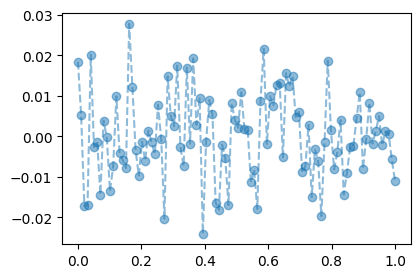

In [18]:
torch.manual_seed(5) 
x = torch.linspace(0,1,100).reshape(100,1)
y = torch.randn(100).reshape(100,1)*0.01
plt.plot(x,y,'--o',alpha=0.5)

In [19]:
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(1,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(1000):
    ## step1 
    yhat = net(x) 
    ## step2 
    loss = loss_fn(yhat,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

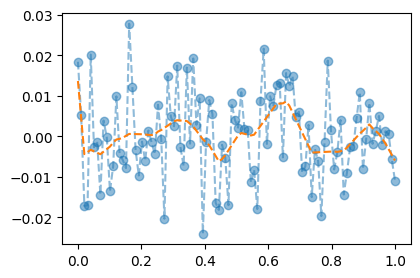

In [20]:
plt.plot(x,y,'--o',alpha=0.5)
plt.plot(x,net(x).data,'--')

## C. 오버피팅이라는 뚜렷한 증거! (train / test)

`-` 데이터의 분리하여 보자.

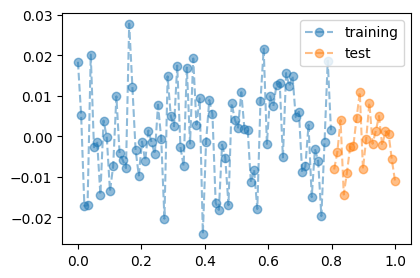

In [21]:
torch.manual_seed(5) 
x_all = torch.linspace(0,1,100).reshape(100,1)
y_all = torch.randn(100).reshape(100,1)*0.01
x,xx = x_all[:80], x_all[80:]
y,yy = y_all[:80], y_all[80:]
plt.plot(x,y,'--o',alpha=0.5,label="training")
plt.plot(xx,yy,'--o',alpha=0.5,label="test")
plt.legend()

`-` train만 학습

In [22]:
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(1,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(1000):
    ## step1 
    yhat = net(x) 
    ## step2 
    loss = loss_fn(yhat,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

`-` training data로 학습한 net를 training data 에 적용

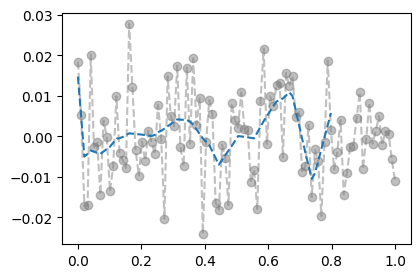

In [23]:
plt.plot(x_all,y_all,'--o',alpha=0.5,color="gray")
plt.plot(x,net(x).data,'--')

-   training에서는 그럭저럭 잘 맞춤

`-` training data로 학습한 net를 test data 에 적용

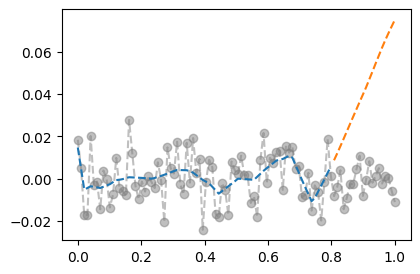

In [24]:
plt.plot(x_all,y_all,'--o',alpha=0.5,color="gray")
plt.plot(x,net(x).data,'--')
plt.plot(xx,net(xx).data,'--')

-   train에서는 그럭저럭 잘 맞추는데 test에서는 엉망이다 = overfit

## D. 시벤코정리의 올바른 이해

> **Note**
>
> **시벤코의 항변(?)** (Cybenko 1989)
>
> 하나의 은닉층을 가지는 아래와 같은 꼴의 네트워크
> $net: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$는
>
> ``` python
> net = torch.nn.Sequential(
>     torch.nn.Linear(p,???),
>     torch.nn.Sigmoid(), ## <-- 여기에 렐루를 써도 된다. 
>     torch.nn.Linear(???,q)
> )
> ```
>
> 모든 보렐가측함수
>
> $$f: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$$
>
> 를 원하는 정확도로 “근사”시킬 수 있다. 쉽게 말하면
> ${\bf X} \to {\bf y}$ 인 어떠한 복잡한 규칙라도 하나의 은닉층을 가진
> 신경망이 원하는 정확도로 근사시킨다는 의미이다. **그렇지만 이러한
> 규칙이 네크워크가 학습하지 못했던 자료 (처음 보는 자료, unseen data)**
> ${\bf XX}_{m \times p}$, ${\bf yy}_{m \times q}$ **에 대하여서도
> 올바르게 적용된다라는 보장은 없다**. 시벤코는 단지 `net`가 가지는
> 표현력의 한계를 수학적으로 밝혔을 뿐이다.

# 5. 드랍아웃

## A. 오버피팅의 해결

`-` 오버피팅의 해결책: 드랍아웃

`-` 데이터

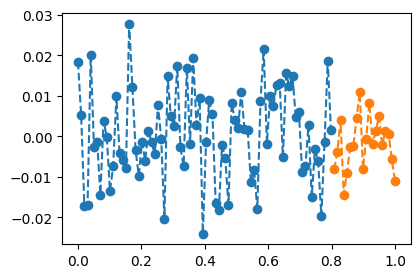

In [19]:
torch.manual_seed(5) 
x_all = torch.linspace(0,1,100).reshape(100,1)
y_all = torch.randn(100).reshape(100,1)*0.01
#plt.plot(x_all,y_all,'--o',alpha=0.5)
x,y = x_all[:80], y_all[:80]
xx,yy = x_all[80:], y_all[80:]
plt.plot(x,y,'--o',color="C0")
plt.plot(xx,yy,'--o',color="C1")

`-` 학습

In [160]:
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(1,512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.8),
    torch.nn.Linear(512,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(1000):
    ## step1 
    yhat = net(x) 
    ## step2 
    loss = loss_fn(yhat,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화 (잘못된 사용)

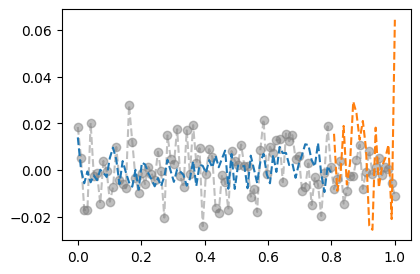

In [161]:
plt.plot(x_all,y_all,'--o',alpha=0.5,color="gray")
plt.plot(x,net(x).data,'--')
plt.plot(xx,net(xx).data,'--')

`-` 결과시각화 (올바른 사용)

In [162]:
net.training 

In [163]:
net.eval()

In [164]:
net.training

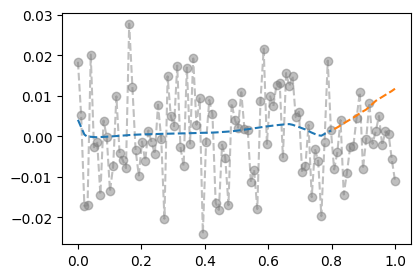

In [165]:
plt.plot(x_all,y_all,'--o',alpha=0.5,color="gray")
plt.plot(x,net(x).data,'--')
plt.plot(xx,net(xx).data,'--')

## B. 드랍아웃 레이어

`-` 드랍아웃의 성질1: 드랍아웃의 계산방식을 이해해보자.

In [16]:
u = torch.randn(10,2)
d = torch.nn.Dropout(0.9)
u

In [17]:
d(u)

-   90%의 드랍아웃: 드랍아웃층의 입력 중 임의로 90%를 골라서 결과를
    0으로 만든다. + 그리고 0이 되지않고 살아남은 값들은 10배 만큼 값이
    커진다.
-   남은값을 10배 키우는 이유? 출력의 평균값을 보정하기 위해서

`-` 드랍아웃의 성질2: 드랍아웃을 on/off 하는 방법을 이해해보자.

In [18]:
u = torch.randn(10,2)
u

In [19]:
net = torch.nn.Sequential(
    torch.nn.Dropout(0.9)
)
net

In [20]:
u,net(u)

In [21]:
net.training

In [22]:
net.eval() # 드랍아웃이 무력화

In [23]:
u,net(u)

`-` 드랍아웃레이어 정리

-   계산: (1) 입력의 일부를 임의로 0으로 만드는 역할 (2) 0이 안된것들은
    스칼라배하여 드랍아웃을 통과한 모든 숫자들의 총합이 대체로 일정하게
    되도록 조정
-   on/off: 학습시에는 dropout on / 학습을 하지 않을 경우는 dropout off
-   느낌: 일부러 패널티를 안고 학습하는 느낌..
-   효과: 오버피팅을 억제하는 효과가 있음

> 참고: 오버피팅을 잡는 방법은 드랍아웃만 있는게 아니다..

## C. 드랍아웃 레이어의 위치

`-` ReLU,dropout의 특이한 성질:
$\text{dropout}(\text{relu}({\bf x}))=\text{relu}(\text{dropout}({\bf x}))$

In [191]:
u = torch.randn(10,2)
r = torch.nn.ReLU()
d = torch.nn.Dropout()

In [194]:
torch.manual_seed(0)
d(r(u))

In [195]:
torch.manual_seed(0)
r(d(u))

`-` 다른 활성화함수는 성립안함

In [196]:
u = torch.randn(10,2)
s = torch.nn.Sigmoid()
d = torch.nn.Dropout()

In [198]:
torch.manual_seed(0)
d(s(u))

In [199]:
torch.manual_seed(0)
s(d(u))

`-` 결론: 드랍아웃은 활성화 함수 바로 뒤에 오는게 맞음. (그렇지 않다면
0을 만들 수 없는걸?) 그렇지만 ReLU의 경우 활성화 함수 직전에 취하기도
함.

## D. 평균보정의 필요성 (선택학습)

> **Note**
>
> 90%의 드랍아웃에서 출력결과에 왜 x10하는지 좀 더 자세히 설명한
> 챕터입니다. 궁금하시다면 읽어보시고 아니라면 넘어가셔도 무방합니다.

`-` 아래의 데이터를 관찰하자.

In [803]:
x,_ = torch.randn(300).sort()
y = relu(20*x) + torch.randn(300)
x,y = x.reshape(-1,1), y.reshape(-1,1)

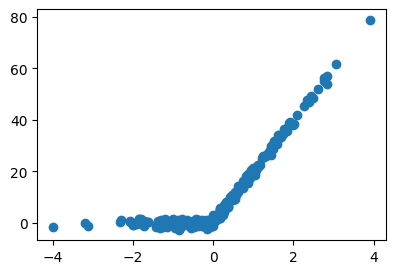

In [804]:
plt.plot(x,y,'o')

`-` 적합해보자.

In [805]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,1000),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(1000,1,bias=False),
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(5000):
    ## 1 
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [806]:
net.eval()

In [807]:
net.training

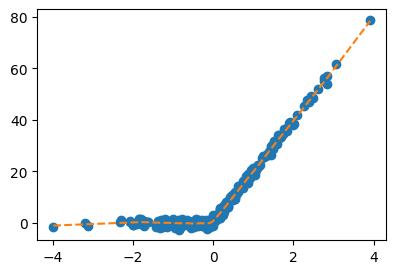

In [808]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--')

`-` 주황색선이나오는 이유 설명해보자.

In [815]:
U = net[:-1](x).data 
W = net[-1].weight.T 

*아래3개는 동일한코드임*

In [819]:
net(x).reshape(-1)[:10] # 코드1

In [820]:
(U@W).reshape(-1)[:10] # 코드2

In [822]:
((U*W.reshape(-1)).sum(axis=1))[:10] # 코드3

*따라서 아래의 주황색선들의 `.sum(axis=1)` 하기만 하면 `net(x)`의 결과가
된다.*

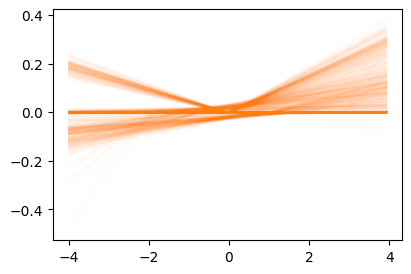

In [823]:
plt.plot(x,U*W.reshape(-1).data,color="C1",alpha=0.02);

`-` 즉 왼쪽의 주황색선[1]이 모두 합쳐져서 오른쪽의 점선이된다.

[1] 1000개가 있음

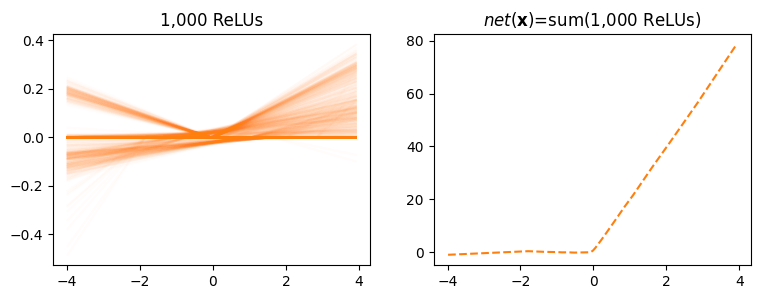

In [834]:
fig,ax = plt.subplots(1,2,figsize=(9,3))
ax[0].plot(x,U*W.reshape(-1).data,color="C1",alpha=0.02);
ax[0].set_title("1,000 ReLUs")
ax[1].plot(x,net(x).data,'--',color="C1")
ax[1].set_title(r"$net({\bf x})$=sum(1,000 ReLUs)");

-   만약에 왼쪽의 주황색선이 10%만 사용되어서 100개의 렐루만
    사용되었다면? 대충 x10을 해줘야 `net(x)` 가 나오지 않겠어요?

Cybenko, George. 1989. “Approximation by Superpositions of a Sigmoidal
Function.” *Mathematics of Control, Signals and Systems* 2 (4): 303–14.